<a href="https://colab.research.google.com/github/COATZ/FlowerShazam/blob/main/Coursera_Assign_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dear reviewer,

First thank you for your time and attention.

---

Today, I propose you to categorize flowers using Deep Learning. 

Searching for an original dataset, I came across the flowers dataset in kaggle ([source](https://www.kaggle.com/spaics/hackathon-blossom-flower-classification) and [source](https://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html)) and decided to work on it. In this dataset, there are 102 types of flowers and I will build a network to be able to recognize them.

---

This problem, is an image processing issue. As a result, I propose to use Convolutional Neural Network to deal with it. A lot of networks architecture are already available so I won't build one from scratch but rather use transfer learning. (ResNet18 and ResNet101 will be tested).

---

I hope you will appreciate my work and results. Feel free to play with it and apply it on your own pictures of flowers.





# **Managing all the imports**

In [ ]:
import os, os.path
from __future__ import print_function
from __future__ import division

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

%load_ext tensorboard

import time
import os, sys

import copy
import json

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from google.colab import drive
drive.mount('/content/gdrive')

PyTorch Version:  1.8.1+cu101
Torchvision Version:  0.9.1+cu101
cuda:0
Mounted at /content/gdrive


# **Loading the Flower dataset from Kaggle**

[Source](https://www.kaggle.com/lenine/flower-102diffspecies-dataset)

In [ ]:
! pip install -q kaggle
#from google.colab import files
#files.upload()
! mkdir ~/.kaggle
! cp /content/gdrive/MyDrive/Coursera_Assign/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

mkdir: cannot create directory ‘/root/.kaggle’: File exists
ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              223KB  2021-04-15 14:58:54           2821  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-02-17 16:10:44           1679  
dhruvildave/wikibooks-dataset                               Wikibooks Dataset                                   1GB  2021-02-18 10:08:27           1166  
promptcloud/careerbuilder-job-listing-2020                  Careerbuilder Job Listing 2020                     42MB  2021-03-05 06:59:52            299  
imsparsh/musicne

In [ ]:
!kaggle datasets download -d spaics/hackathon-blossom-flower-classification
!mkdir flower_dataset
!unzip /content/hackathon-blossom-flower-classification.zip -d flower_dataset/

Streaming output truncated to the last 5000 lines.
  inflating: flower_dataset/flower_data/flower_data/train/51/image_01359.jpg  
  inflating: flower_dataset/flower_data/flower_data/train/51/image_01360.jpg  
  inflating: flower_dataset/flower_data/flower_data/train/51/image_01361.jpg  
  inflating: flower_dataset/flower_data/flower_data/train/51/image_01364.jpg  
  inflating: flower_dataset/flower_data/flower_data/train/51/image_01365.jpg  
  inflating: flower_dataset/flower_data/flower_data/train/51/image_01366.jpg  
  inflating: flower_dataset/flower_data/flower_data/train/51/image_01367.jpg  
  inflating: flower_dataset/flower_data/flower_data/train/51/image_01368.jpg  
  inflating: flower_dataset/flower_data/flower_data/train/51/image_01369.jpg  
  inflating: flower_dataset/flower_data/flower_data/train/51/image_01371.jpg  
  inflating: flower_dataset/flower_data/flower_data/train/51/image_01372.jpg  
  inflating: flower_dataset/flower_data/flower_data/train/51/image_01373.jpg  
 

# **Checking the Flower dataset**

Checking the train and test dataset folders.

In [ ]:
path_flower = 'flower_dataset/flower_data/flower_data/'
path_flower_train = path_flower+'/train/'
path_flower_test = path_flower+'/valid/'
# Train set
print('Number of folders in the train set: ',len(os.listdir(path_flower_train)))
print('Number of files in the train set: ',sum([len(files) for r, d, files in os.walk(path_flower_train)]))

# Test set
print('Number of folders in the test set: ',len(os.listdir(path_flower_test)))
print('Number of files in the test set: ',sum([len(files) for r, d, files in os.walk(path_flower_test)]))

Number of folders in the train set:  102
Number of files in the train set:  6552
Number of folders in the test set:  102
Number of files in the test set:  818


Checking the list of category of flowers. We are expecting 102 categories so we must check we have 102 differents categories in the train dataset.

In [ ]:
json_flowers = '/content/flower_dataset/cat_to_name.json'
list_flowers = json.load(open(json_flowers,'r'))
print(list_flowers)
print('Number of flower categories: ',len(list_flowers))
if len(os.listdir(path_flower_train))!=len(list_flowers):
  sys.exit('Not a good number of categories in train set')

{'21': 'fire lily', '3': 'canterbury bells', '45': 'bolero deep blue', '1': 'pink primrose', '34': 'mexican aster', '27': 'prince of wales feathers', '7': 'moon orchid', '16': 'globe-flower', '25': 'grape hyacinth', '26': 'corn poppy', '79': 'toad lily', '39': 'siam tulip', '24': 'red ginger', '67': 'spring crocus', '35': 'alpine sea holly', '32': 'garden phlox', '10': 'globe thistle', '6': 'tiger lily', '93': 'ball moss', '33': 'love in the mist', '9': 'monkshood', '102': 'blackberry lily', '14': 'spear thistle', '19': 'balloon flower', '100': 'blanket flower', '13': 'king protea', '49': 'oxeye daisy', '15': 'yellow iris', '61': 'cautleya spicata', '31': 'carnation', '64': 'silverbush', '68': 'bearded iris', '63': 'black-eyed susan', '69': 'windflower', '62': 'japanese anemone', '20': 'giant white arum lily', '38': 'great masterwort', '4': 'sweet pea', '86': 'tree mallow', '101': 'trumpet creeper', '42': 'daffodil', '22': 'pincushion flower', '2': 'hard-leaved pocket orchid', '54': 's

In [ ]:
nb_folders_train = len(os.listdir(path_flower_train))
nb_folders_valid = len(os.listdir(path_flower_test)) 
nb_files_train = []
nb_files_valid = []
for idx in range(nb_folders_train):
  nb_files_train.append(len([files for files in os.listdir(path_flower_train+str(idx+1)+'/')]))
for idx in range(nb_folders_valid):
  nb_files_valid.append(len([files for files in os.listdir(path_flower_test+str(idx+1)+'/')]))
print("Mean of images in train folders= ",np.mean(nb_files_train))
print("Mean of images in test folders= ",np.mean(nb_files_valid))
from operator import truediv
ratio_files = list(map(truediv, nb_files_train, nb_files_valid))
print("Mean ratio between images in train and test folders= ",np.mean(ratio_files))

Mean of images in train folders=  64.23529411764706
Mean of images in test folders=  8.019607843137255
Mean ratio between images in train and test folders=  10.331742979815735


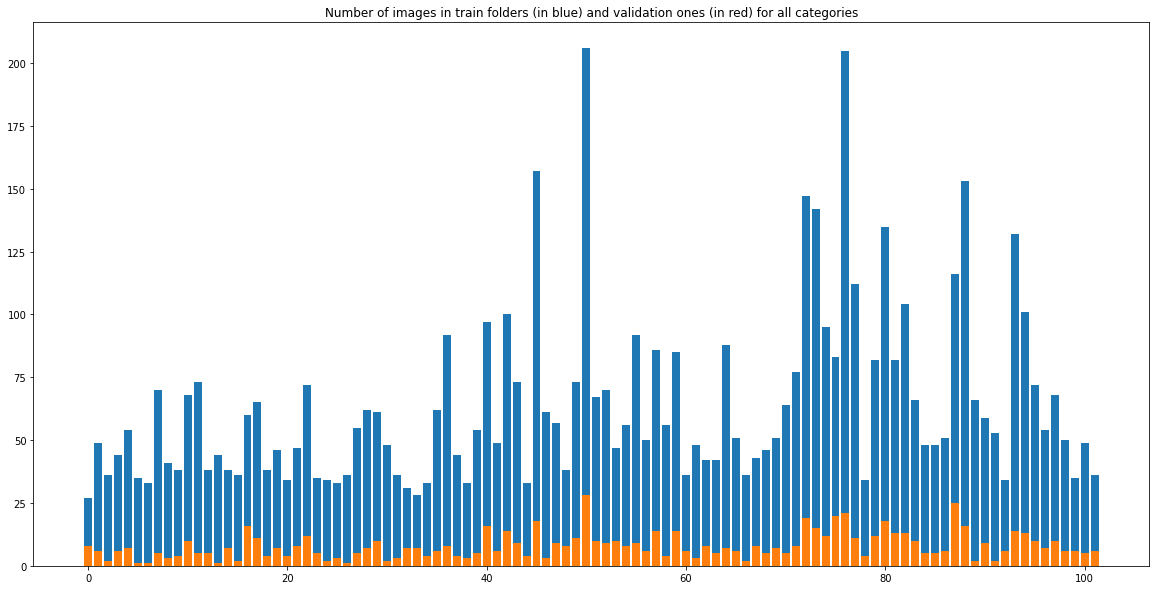

In [ ]:
plt.figure(figsize=(20,10))
plt.bar(np.arange(nb_folders_train),nb_files_train)
plt.bar(np.arange(nb_folders_train),nb_files_valid)
plt.title('Number of images in train folders (in blue) and validation ones (in red) for all categories')
plt.show()

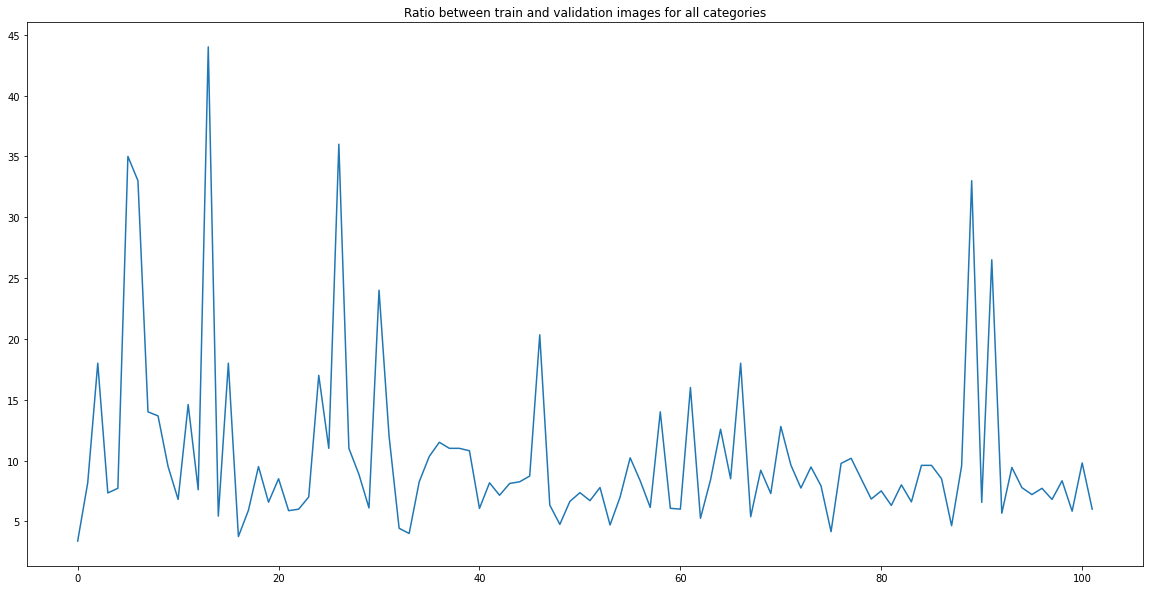

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(ratio_files)
plt.title('Ratio between train and validation images for all categories')
plt.show()

Our train dataset presents a good repartition of images in the 102 categories with in mean 64 images per category. For the validation dataset there is 8 images per folders in mean, which allow us to test all the categories when validating our final solution.

# **Prepare the datasets:**
In order to uniformize the data fed to the CNN, we will apply some image transformation. Based on [source](https://pytorch.org/vision/stable/models.html), we will apply here:


1.   Resize the images with dimension 256
2.   Crop the images with dimension 224
3.   Normalize them by estimating the Mean and Std of the train dataset for Red, Green and Blue values.

Usually, ImageNet values are used: 
```
MEANS = [0.485, 0.456, 0.406]
STANDARD_DEVIATIONS = [0.229, 0.224, 0.225]
```
but here, we will compute the values to be more precise.

In [ ]:
CROP_DIMENSION = 224
RESIZE_DIMENSION = 256
transform = transforms.Compose([transforms.Resize(RESIZE_DIMENSION), transforms.CenterCrop(CROP_DIMENSION), transforms.ToTensor()])
dataset = datasets.ImageFolder(path_flower_train, transform=transform)

means = []
stds = []

for img in dataset:
    means.append(torch.mean(img[0],[1,2],True).squeeze().numpy())
    stds.append(torch.mean(img[0],[1,2],True).squeeze().numpy())
    #print(torch.mean(img[0],[1,2],True).squeeze())

Our mean and std parameters will be:

In [ ]:
mean_tmp = torch.mean(torch.tensor(means),0,True).squeeze().numpy()
std_tmp = torch.mean(torch.tensor(stds),0,True).squeeze().numpy()
print('Mean: ',mean_tmp,' Std: ',std_tmp)

MEANS = mean_tmp
STANDARD_DEVIATIONS = std_tmp

Mean:  [0.5178362  0.41067493 0.32864168]  Std:  [0.5178362  0.41067493 0.32864168]


So now we can uniformize our train and test datasets accordindgly.

In [ ]:
BATCH_SIZE = 64

#ImageNet Means and Stds
#MEANS = [0.485, 0.456, 0.406]
#STANDARD_DEVIATIONS = [0.229, 0.224, 0.225]

#Adapted Means and Stds for this dataset
MEANS = mean_tmp
STANDARD_DEVIATIONS = std_tmp

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(RESIZE_DIMENSION),
        transforms.CenterCrop(CROP_DIMENSION),
        transforms.ToTensor(),
        transforms.Normalize(MEANS, STANDARD_DEVIATIONS)
    ]),
    'valid': transforms.Compose([
        transforms.Resize(RESIZE_DIMENSION),
        transforms.CenterCrop(CROP_DIMENSION),
        transforms.ToTensor(),
        transforms.Normalize(MEANS, STANDARD_DEVIATIONS)
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(path_flower, x), data_transforms[x]) for x in ['train', 'valid']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=2) for x in ['train', 'valid']}

# Get names of the classes within each dataset
train_class_idx = image_datasets['train'].class_to_idx
valid_class_idx = image_datasets['valid'].class_to_idx

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...


Some functions for plotting.

In [ ]:
def get_dictionary_key(dictionary, value):
    return {val: key for key, val in dictionary.items()}[value]

def displayImage(image, image_name=None, normalize=True, mean_disp=MEANS, std_disp=STANDARD_DEVIATIONS):
    forDisplay = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array(MEANS)
        standard_deviation = np.array(STANDARD_DEVIATIONS)
        forDisplay = standard_deviation * forDisplay + mean
        forDisplay = np.clip(forDisplay, 0, 1)
    
    fig, ax = plt.subplots()
    ax.imshow(forDisplay)
    ax.set_axis_off()
    
    if image_name:
        ax.set_title(image_name)
        
    plt.show()
    
def plot_flowers(tensor, tensor_class_idx, count=1, normalize=True):
    
    images, labels = next(tensor)
    a = np.floor(count**0.5).astype(int)
    b = np.ceil(1.*count/a).astype(int)
    fig = plt.figure(figsize=(3.*b,3.*a))
    for i in range(1,count+1):
        ax = fig.add_subplot(a,b,i)
        ax.plot([1,2,3],[1,2,3])
        forDisplay = images[i].numpy().transpose((1, 2, 0))

        if normalize:
            mean = np.array(MEANS)
            standard_deviation = np.array(STANDARD_DEVIATIONS)
            forDisplay = standard_deviation * forDisplay + mean
            forDisplay = np.clip(forDisplay, 0, 1)
        ax.imshow(forDisplay)
        ax.set_title(list_flowers.get(get_dictionary_key(tensor_class_idx, labels[i].item())))
        ax.set_axis_off()
    #fig.suptitle("%d Flowers" % count, fontsize=16)
    
    plt.show()
    
def display_image_label(tensor, tensor_class_idx, count=1):
    images, labels = next(tensor)
    for i in range(count):
        displayImage(images[i], list_flowers.get(get_dictionary_key(tensor_class_idx, labels[i].item())))

Display the picture of an item in the train dataset with its label.


1.   No normalization
2.   Normalization ImageNet
3.   Normalization estimated for flower dataset



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


No normalization


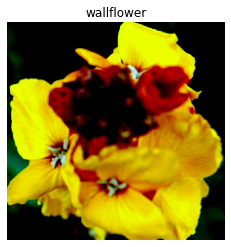

Normalization ImageNet


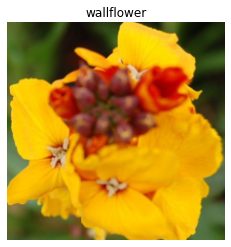

Normalization Flowers


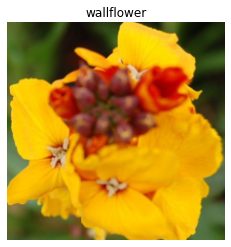

In [ ]:
mini_batch_tmp = next(iter(dataloaders_dict['train']))
first_image = mini_batch_tmp[0][0]
first_label = mini_batch_tmp[1][0]
print('No normalization')
displayImage(first_image,list_flowers.get(get_dictionary_key(train_class_idx, first_label.item())),False)
print('Normalization ImageNet')
displayImage(first_image,list_flowers.get(get_dictionary_key(train_class_idx, first_label.item())),True,[0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
print('Normalization Flowers')
displayImage(first_image,list_flowers.get(get_dictionary_key(train_class_idx, first_label.item())),True,MEANS,STANDARD_DEVIATIONS)

Plotting a fullsubset of 25 images of the train dataset with normalization Flower. We can clearly see that there is a good coherence in terms of size, shape and color between the different pictures. Our dataset is ready to be used for training.

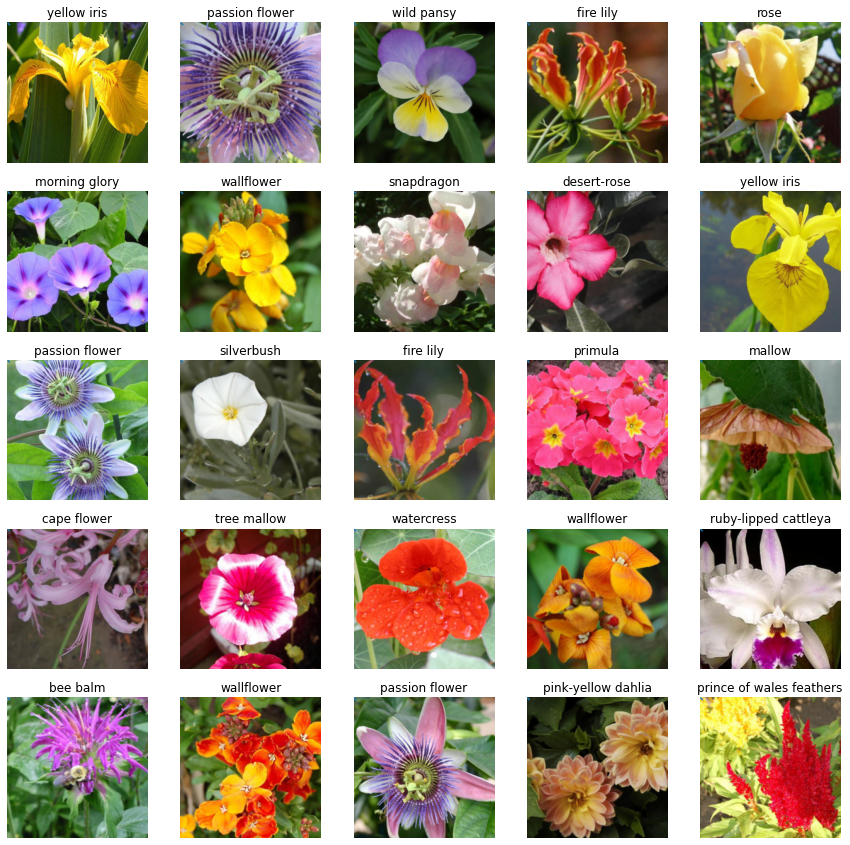

In [ ]:
plot_flowers(iter(dataloaders_dict['train']), train_class_idx, 25, True)

# **Constructing the ANN**
Here, we are trying to class images in several categories. The most straitghfoward solution is to use a Convolution Neural Network for this task. We will do transfer learning as describe in the coursera lessons: using a pretrained network and changing the last layer to adapt to our particular problem. Here we want to classify the flowers in 102 categories.

Ptyhon framework to load and fine-tune CNN directly from torchvision [Source](https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html)

In the first approach we will use Resnet18 for classification in 102 classes with a batch size of 64 and 15 epochs.

In [ ]:
# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "resnet"

# Number of classes in the dataset
num_classes = 102

# Batch size for training (change depending on how much memory you have)
batch_size = 64

# Number of epochs to train for
num_epochs = 15

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

In [ ]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "resnet101":
        """ Resnet101
        """
        model_ft = models.resnet101(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size



In [ ]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [ ]:
# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
 

Loading the ResNet18 from torchvision models and printing its architecture. We can see that its architecture is coherent with the expected convolution layers. Besides, the last layer :``` (fc): Linear(in_features=512, out_features=102, bias=True) ``` show that we will predict 102 categories as output of the CNN.



[Source](https://pytorch.org/assets/images/resnet.png)

# **Train the model**

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'valid':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [ ]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

Params to learn:
	 fc.weight
	 fc.bias


In [ ]:
# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/14
----------
train Loss: 4.2793 Acc: 0.1044
valid Loss: 3.7763 Acc: 0.2555

Epoch 1/14
----------
train Loss: 3.4505 Acc: 0.3333
valid Loss: 3.0943 Acc: 0.3998

Epoch 2/14
----------
train Loss: 2.8474 Acc: 0.4777
valid Loss: 2.6041 Acc: 0.5049

Epoch 3/14
----------
train Loss: 2.3973 Acc: 0.5876
valid Loss: 2.2159 Acc: 0.6137

Epoch 4/14
----------
train Loss: 2.0565 Acc: 0.6787
valid Loss: 1.9284 Acc: 0.6932

Epoch 5/14
----------
train Loss: 1.7874 Acc: 0.7437
valid Loss: 1.6898 Acc: 0.7311

Epoch 6/14
----------
train Loss: 1.5708 Acc: 0.7845
valid Loss: 1.5088 Acc: 0.7665

Epoch 7/14
----------
train Loss: 1.3987 Acc: 0.8240
valid Loss: 1.3774 Acc: 0.8081

Epoch 8/14
----------
train Loss: 1.2608 Acc: 0.8442
valid Loss: 1.2400 Acc: 0.8313

Epoch 9/14
----------
train Loss: 1.1376 Acc: 0.8643
valid Loss: 1.1480 Acc: 0.8435

Epoch 10/14
----------
train Loss: 1.0393 Acc: 0.8819
valid Loss: 1.0565 Acc: 0.8667

Epoch 11/14
----------
train Loss: 0.9639 Acc: 0.8915
valid Loss

Save the model for re-use:

In [ ]:
# Save the model checkpoint
torch.save(model_ft.state_dict(), 'resnet18.ckpt')

# **Transfer learning**

Comparing to the non-pretrained version of the model:

Epoch 0/14
----------
train Loss: 4.3959 Acc: 0.0650
valid Loss: 4.0631 Acc: 0.1088

Epoch 1/14
----------
train Loss: 3.8568 Acc: 0.1340
valid Loss: 3.7181 Acc: 0.1394

Epoch 2/14
----------
train Loss: 3.5058 Acc: 0.1853
valid Loss: 3.4195 Acc: 0.2017

Epoch 3/14
----------
train Loss: 3.2402 Acc: 0.2195
valid Loss: 3.2038 Acc: 0.2262

Epoch 4/14
----------
train Loss: 3.0381 Acc: 0.2517
valid Loss: 3.0101 Acc: 0.2421

Epoch 5/14
----------
train Loss: 2.8568 Acc: 0.2837
valid Loss: 2.9517 Acc: 0.2384

Epoch 6/14
----------
train Loss: 2.7257 Acc: 0.3027
valid Loss: 2.7339 Acc: 0.3191

Epoch 7/14
----------
train Loss: 2.5973 Acc: 0.3397
valid Loss: 2.5938 Acc: 0.3313

Epoch 8/14
----------
train Loss: 2.4837 Acc: 0.3687
valid Loss: 2.4844 Acc: 0.3557

Epoch 9/14
----------
train Loss: 2.3778 Acc: 0.3964
valid Loss: 2.4730 Acc: 0.3631

Epoch 10/14
----------
train Loss: 2.2578 Acc: 0.4272
valid Loss: 2.3382 Acc: 0.3839

Epoch 11/14
----------
train Loss: 2.1949 Acc: 0.4327
valid Loss

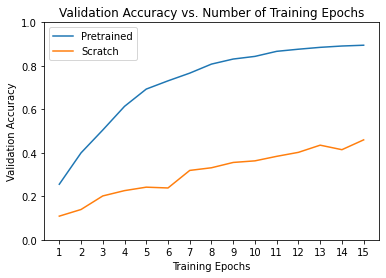

In [ ]:
# Initialize the non-pretrained version of the model used for this run
scratch_model,_ = initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=False)
scratch_model = scratch_model.to(device)
scratch_optimizer = optim.SGD(scratch_model.parameters(), lr=0.001, momentum=0.9)
scratch_criterion = nn.CrossEntropyLoss()
_,scratch_hist = train_model(scratch_model, dataloaders_dict, scratch_criterion, scratch_optimizer, num_epochs=num_epochs, is_inception=(model_name=="inception"))

# Plot the training curves of validation accuracy vs. number
#  of training epochs for the transfer learning method and
#  the model trained from scratch
ohist = []
shist = []

ohist = [h.cpu().numpy() for h in hist]
shist = [h.cpu().numpy() for h in scratch_hist]

plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),ohist,label="Pretrained")
plt.plot(range(1,num_epochs+1),shist,label="Scratch")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

The benefits of transfer learning are obvious from these graphs. With the same number of epochs, the accuracy reached by the pre-trained model is greatly better than the scratch model. After 15 epochs, the final accuracy of the pretrained model is **0.894866** whereas it is **0.447433** for the one from scratch.

In [ ]:
# Save the model checkpoint
torch.save(scratch_model.state_dict(), 'scratch_resnet18.ckpt')

# **Testing the fine-tuned model**
Functions for testing images.

In [ ]:
def size_image(image):
    width, height = image.size
    return width, height;

def create_thumbnail(image, width, height, short_side):
    if width < height:
        return short_side, height;
    else:
        return width, short_side;
    
def test_process(image):
    preprocess = data_transforms['valid']
   
    img_pil = Image.open(image)
    print(img_pil)
    img_tensor = preprocess(img_pil)
    print(img_tensor.size())
    img_np = img_tensor.numpy()
    print(img_np.shape)
    #img_tensor.unsqueeze_(0)
    return img_np
    
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array'''
    preprocess = data_transforms['valid']
    
    pil_image = Image.open(image)
    tensor_image = preprocess(pil_image)
    numpy_image = tensor_image.numpy()
    
    return numpy_image

In [ ]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    if title is not None:
        ax.set_title(title)
    ax.axis('off')    
    ax.imshow(image)
    
    return ax
    
def process_image_tensor(image_path):
    process_transforms = data_transforms['valid']   
    pil_image = Image.open(image_path)
    tensor_image = process_transforms(pil_image)  
    return tensor_image

def convert_labels(labels, class_idx):    
    names_array = np.array([])
    for i in np.nditer(labels.cpu().numpy()):
        names_array = np.append(names_array, list_flowers.get(get_dictionary_key(class_idx, i.item())))
    return names_array

def predict(image_path, model, class_idx, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    model.to(device)
    model.eval()
    image_tensor = process_image_tensor(image_path).unsqueeze_(0)
    #image_tensor = image_tensor.cuda()
    #model.to(check_gpu())
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        output = model.forward(image_tensor)
    
    probabilities = torch.exp(output)
    probs, labels = probabilities.topk(topk)
    
    #print(probs)
    #print(labels)
    #Convert labels to numpy array of names
    
    #print("Labels:%s" %labels)
    #names = list(list_flowers.values())
    #tests = [names[x] for x in labels[0]]
    return probs.cpu().numpy()[0], convert_labels(labels, class_idx);
    
#print(predict(valid_dir + '/46/image_01034.jpg', neural_network_model))

def get_category_num(image_path):
    return image_path.split('/')[-2]

def get_dataset_subtype(image_path):
    return image_path.split('/')[-3]

def get_class_idx(image_path):
    return dataset_info[get_dataset_subtype(image_path)]['class_idx']

# Display an image along with the top 5 classes
def view_class_probability(image_path, neural_network_model, class_idx):
    probabilities, classes = predict(image_path, neural_network_model, class_idx)
    
    image_elements = image_path.split('/')    
    flower_category_num = image_elements[-2]
    class_type = image_elements[-3]
    #print(dataset_info[class_type]['class_idx'])
    
    fig, (ax1, ax2) = plt.subplots(figsize = (6,10), ncols=2)
    ax1 = plt.subplot(2,1,1)
    imshow(process_image(image_path), ax1)
    
    # Set up title
    title = list_flowers.get(str(flower_category_num))
    # Plot flower
    img = process_image(image_path)
    imshow(img, ax1, title);
    ax2 = fig.add_subplot(2,1,2)
    y_pos = np.arange(len(classes))
    #print(probabilities)
    '''performance = np.around(probabilities, decimals = 3)'''
    
    #print(performance)
    error = np.random.rand(len(classes))

    ax2.barh(y_pos, probabilities, align='center',
        color='blue')
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(classes)
    ax2.invert_yaxis()  # labels read top-to-bottom
    ax2.set_xlabel('Probability')
    ax2.set_title('Class Probability')
    plt.tight_layout()

Test on images from the valid dataset

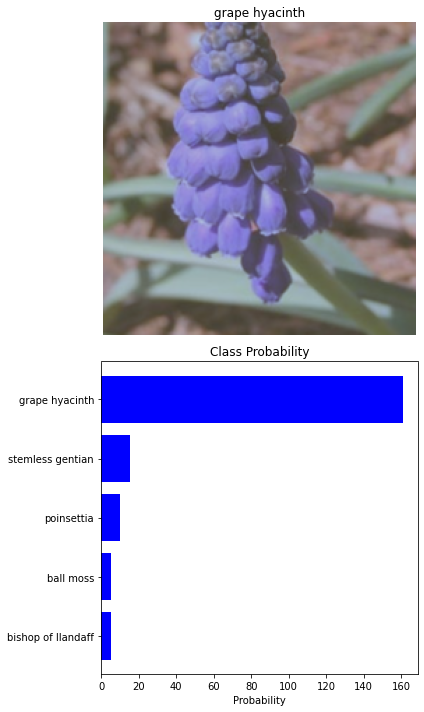

In [ ]:
image1 = path_flower_test + '/25/image_06572.jpg'
view_class_probability(image1, model_ft, valid_class_idx)

For the image above, the prediction given by the pretrained model is very good. The classification is good and the network is really confident on its prediction. The probability for grape hyacinth is a lot higher than the rest of the prediction probabilities meaning the network is confident in its prediction. 

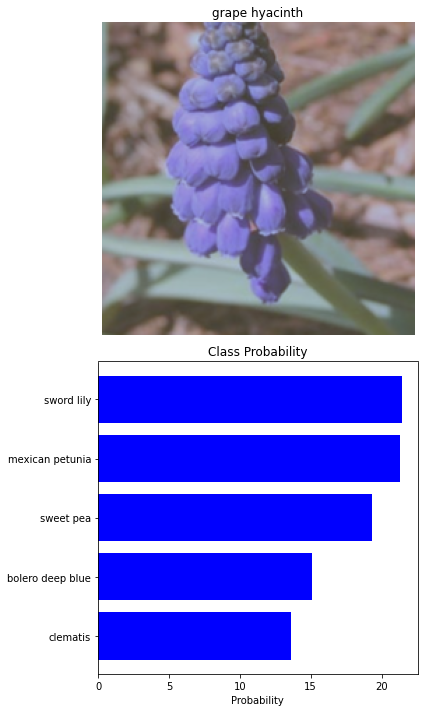

In [ ]:
view_class_probability(image1, scratch_model, valid_class_idx)

The prediction for the same image from the scratch model is wrong and the network clearly hesitates between several categories (the good one is not even shown here). This illustrates again the strenght of transfer learning.

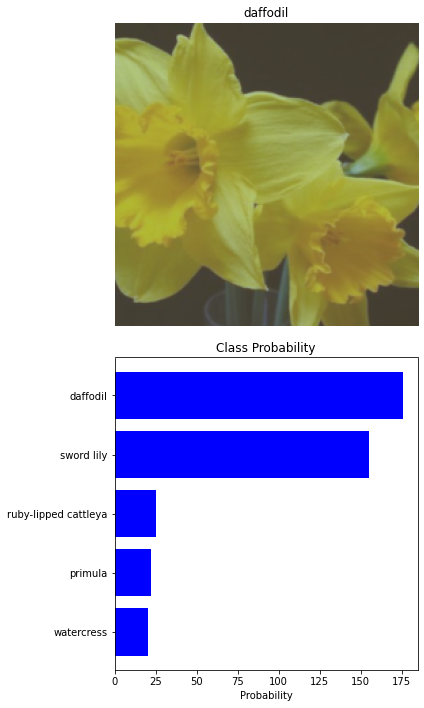

In [ ]:
image2 = path_flower_test + '/42/image_05712.jpg'
view_class_probability(image2, model_ft, valid_class_idx)

In this example, the pretrained network is guessing the good category but clearly hesitates between two close predictions.

# **Test on my own images**
I took picture of some flowers close to me and tried to apply the model to predict the flower category. The pictures exposition is often pretty bad and the flower itself is hardly visible in the middle of other flowers comparing to the initial pictures for training and test. But I still wanted to test my algo and try to understand failure cases.

### **Roses**

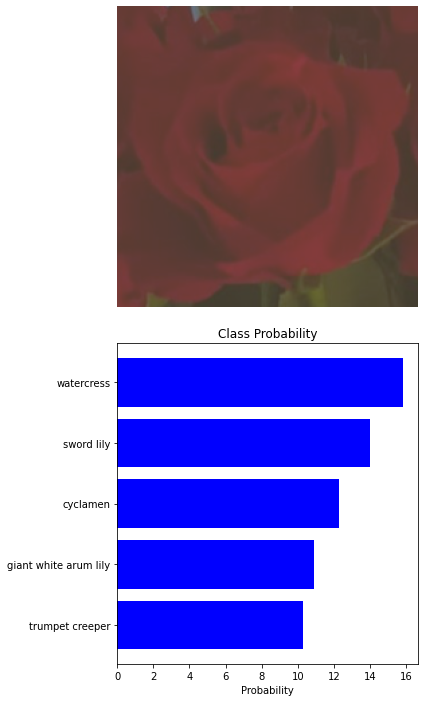

In [ ]:
view_class_probability('/content/test_images/im1.jpeg', model_ft, valid_class_idx)

The network hesitates between several hypothesis with really close probability. Rose is one of it.

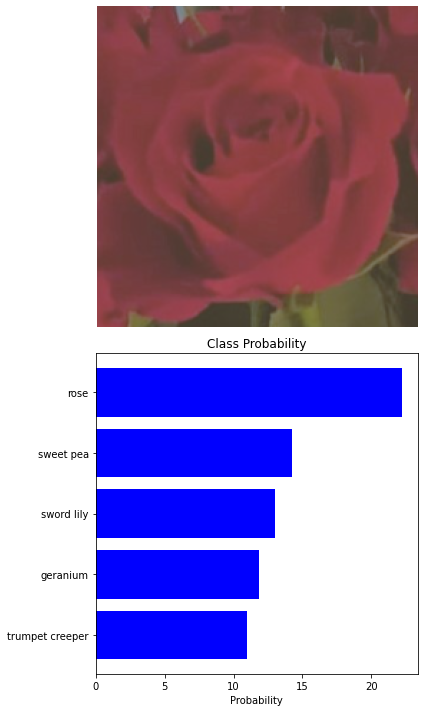

In [ ]:
view_class_probability('/content/test_images/im1_1.jpeg', model_ft, valid_class_idx)

Same picture but more luminosity. This greatly helps the network. Still hesitating between two cases but probabilities are higher.

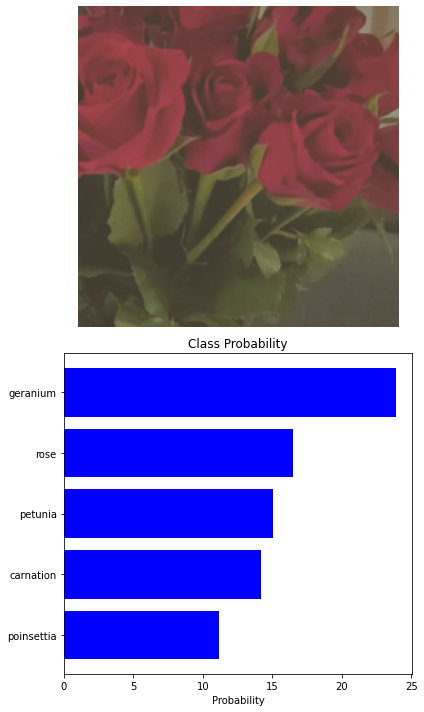

In [ ]:
view_class_probability('/content/test_images/im1_2.jpeg', model_ft, valid_class_idx)

In the middle of bouquet, the network has great problems to extract one flower to predict its class. Training on a dataset of bouquets or an algorithm to extract a region of interest centerd on one flower would help the CNN.

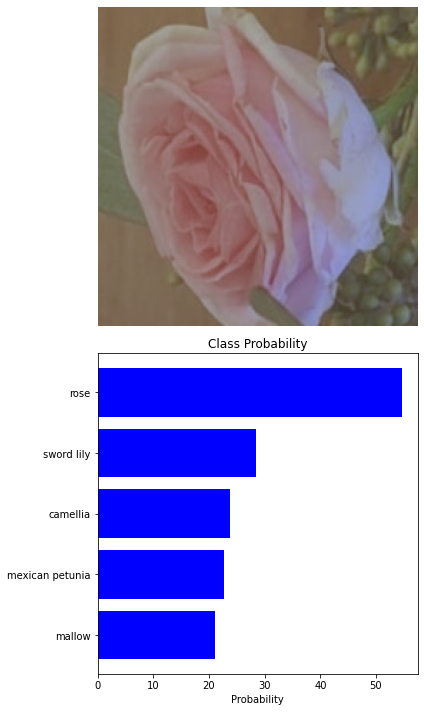

In [ ]:
view_class_probability('/content/test_images/im3.jpeg', model_ft, valid_class_idx)

Good prediction this time but confidence is low. Training with rotated pictures of flowers could help:. For exemple, when building the dataset, we could use these parameters for the data augmentation:
```
ANGLE=30
transforms.RandomRotation(ANGLE), transforms.RandomHorizontalFlip(), transforms.RandomVerticalFlip(),
```



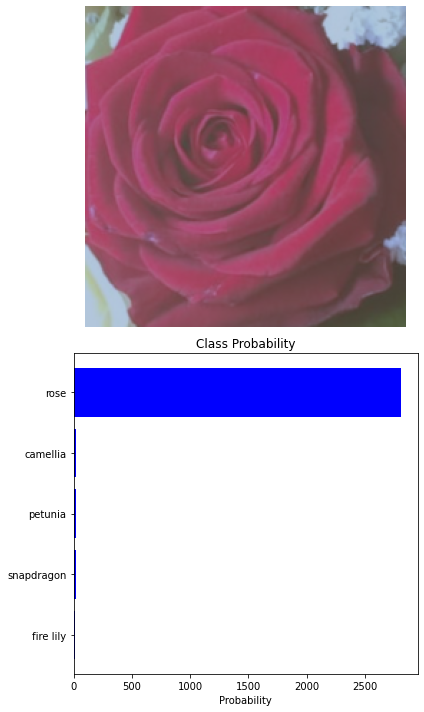

In [ ]:
view_class_probability('/content/test_images/im6.jpeg', model_ft, valid_class_idx)

Great win for this prediction.

### **Mexican Aster**

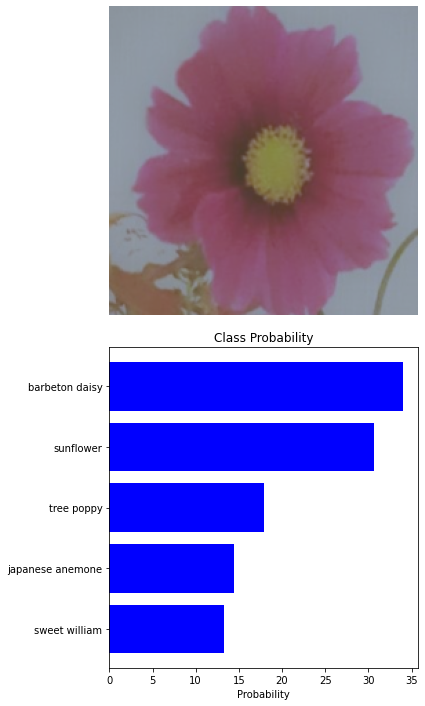

In [ ]:
view_class_probability('/content/test_images/im4.jpeg', model_ft, valid_class_idx)

The network fails on this one. Even guessing a sunflower... The picture quality is not great. I need to improve my skills as flower photograph. ;)

### **Sunflower**

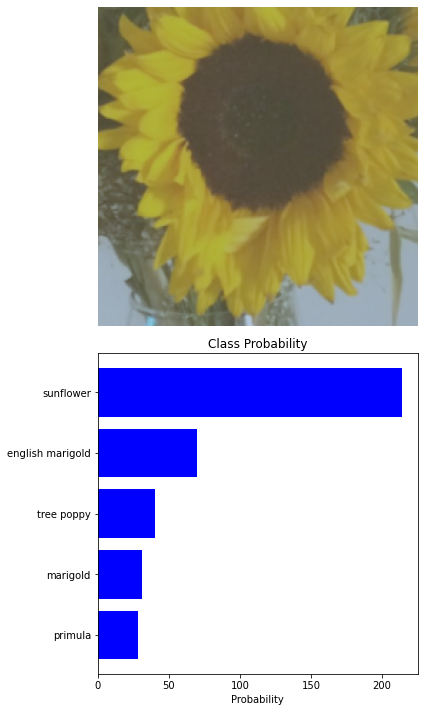

In [ ]:
view_class_probability('/content/test_images/im8.jpeg', model_ft, valid_class_idx)

Great win for this one too.

### **Cyclamen?**

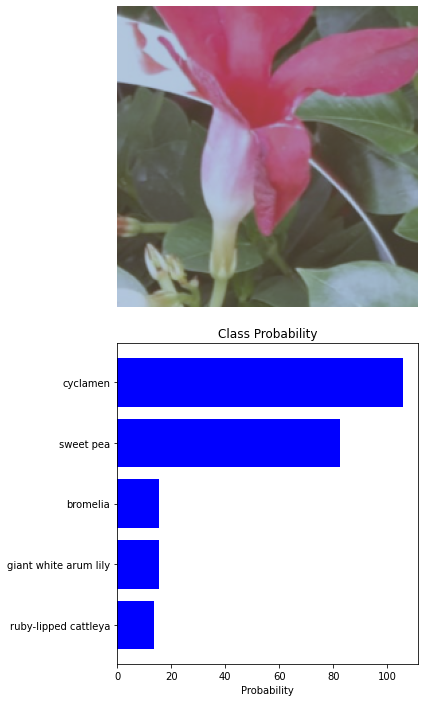

In [ ]:
view_class_probability('/content/test_images/im7.jpeg', model_ft, valid_class_idx)

Not sure about this one. Looking at the pictures of cyclamens (class 88 in the training dataset), it looks like an okay prediction.

### **Barbeton daisy**

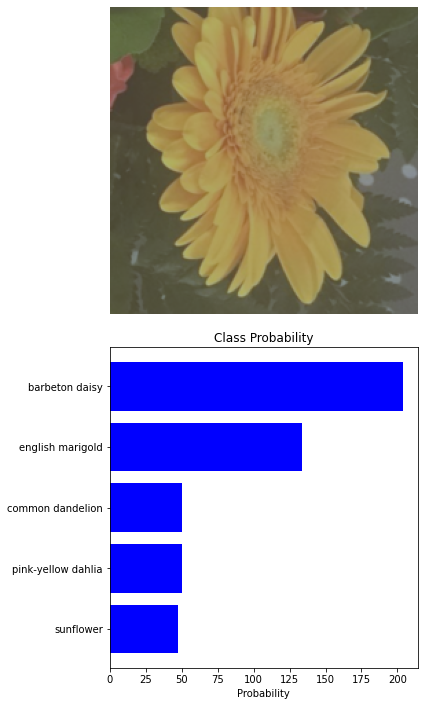

In [ ]:
view_class_probability('/content/test_images/im10.jpeg', model_ft, valid_class_idx)

Good prediction but confidence is low.

# **Annex1: Resnet101**

In [ ]:
# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "resnet101"

# Number of classes in the dataset
num_classes = 102

# Batch size for training (change depending on how much memory you have)
batch_size = 64

# Number of epochs to train for
num_epochs = 15

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

# Initialize the model for this run
model_resnet101, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Send the model to GPU
model_resnet101 = model_resnet101.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_resnet101.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_resnet101.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_resnet101.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()
# Train and evaluate
model_resnet101, hist = train_model(model_resnet101, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Params to learn:
	 fc.weight
	 fc.bias
Epoch 0/14
----------
train Loss: 4.1756 Acc: 0.1459
valid Loss: 3.6928 Acc: 0.3032

Epoch 1/14
----------
train Loss: 3.3495 Acc: 0.3727
valid Loss: 2.9995 Acc: 0.4597

Epoch 2/14
----------
train Loss: 2.7387 Acc: 0.5250
valid Loss: 2.4785 Acc: 0.5856

Epoch 3/14
----------
train Loss: 2.2746 Acc: 0.6482
valid Loss: 2.0866 Acc: 0.6822

Epoch 4/14
----------
train Loss: 1.9276 Acc: 0.7282
valid Loss: 1.7907 Acc: 0.7237

Epoch 5/14
----------
train Loss: 1.6632 Acc: 0.7796
valid Loss: 1.5699 Acc: 0.7824

Epoch 6/14
----------
train Loss: 1.4561 Acc: 0.8268
valid Loss: 1.3855 Acc: 0.8130

Epoch 7/14
----------
train Loss: 1.2870 Acc: 0.8567
valid Loss: 1.2565 Acc: 0.8509

Epoch 8/14
----------
train Loss: 1.1518 Acc: 0.8745
valid Loss: 1.1441 Acc: 0.8655

Epoch 9/14
----------
train Loss: 1.0425 Acc: 0.8961
valid Loss: 1.0480 Acc: 0.8729

Epoch 10/14
----------
train Loss: 0.9485 Acc: 0.9060
valid Loss: 0.9700 Acc: 0.8912

Epoch 11/14
----------
tr

Building on ResNet101 instead of ResNet18, improves the accuracy of our model. After 15 epochs, the final accuracy of the pretrained model is **0.914425** (Train Loss:0.7589 ) whereas it is **0.894866** (Train Loss: 0.8244 ) for the one based on ResNet18.

In [ ]:
# Save the model checkpoint
torch.save(model_resnet101.state_dict(), 'resnet101.ckpt')

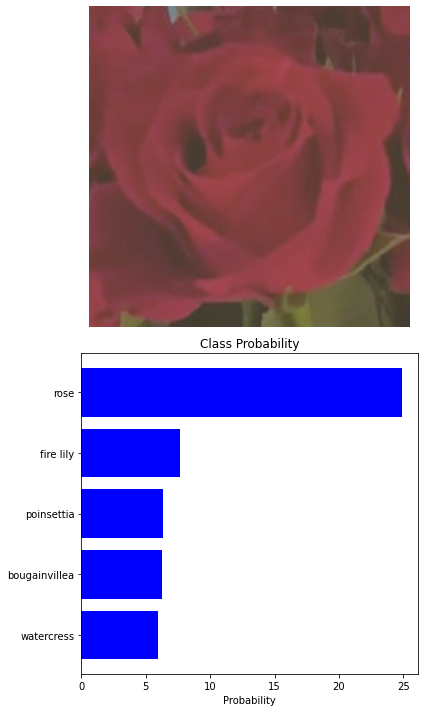

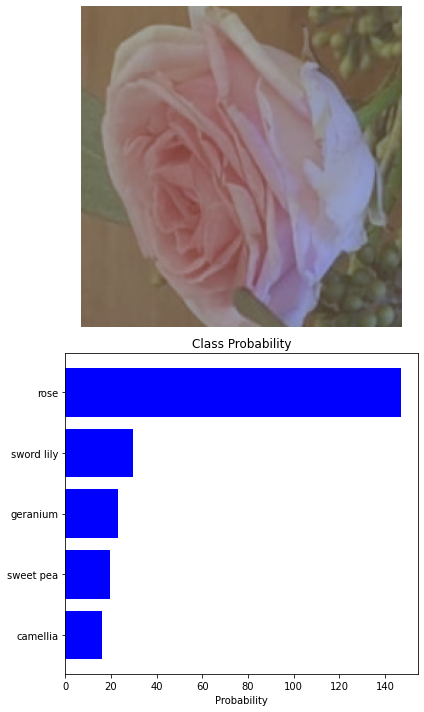

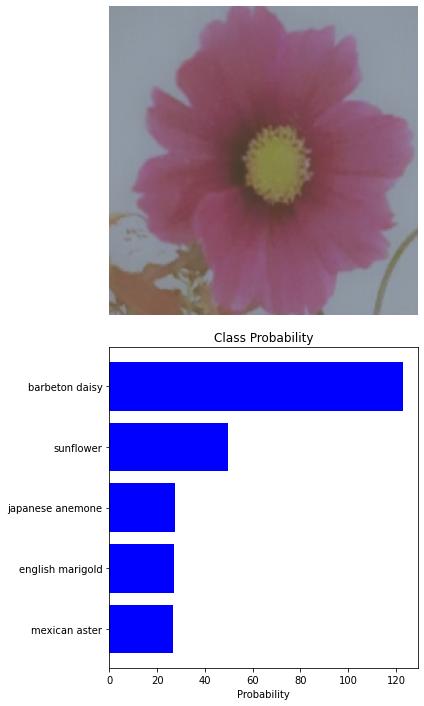

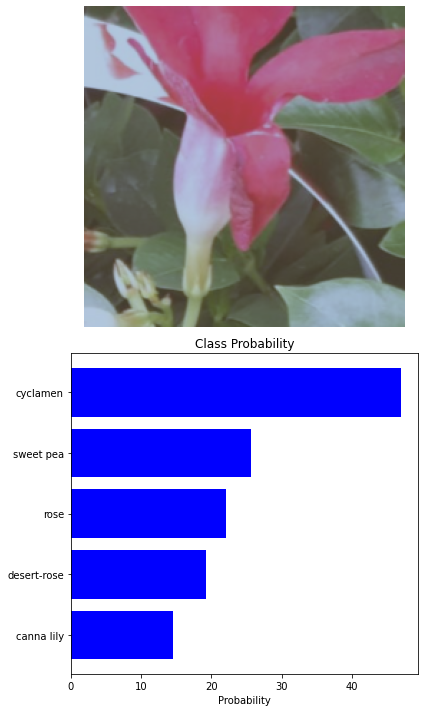

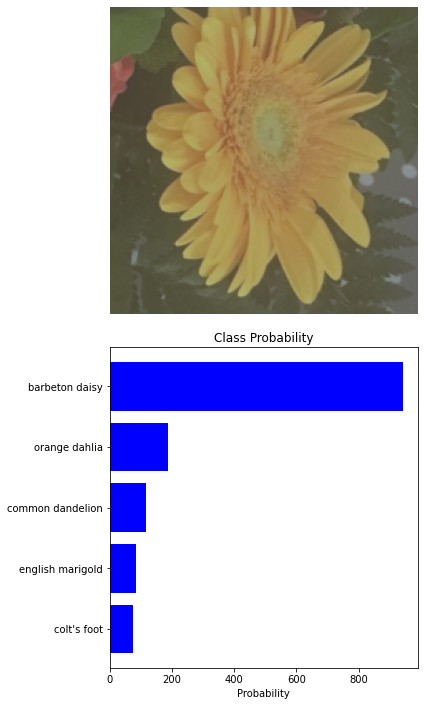

In [ ]:
view_class_probability('/content/test_images/im1_1.jpeg', model_resnet101, valid_class_idx)
view_class_probability('/content/test_images/im3.jpeg', model_resnet101, valid_class_idx)
view_class_probability('/content/test_images/im4.jpeg', model_resnet101, valid_class_idx)
view_class_probability('/content/test_images/im7.jpeg', model_resnet101, valid_class_idx)
view_class_probability('/content/test_images/im10.jpeg', model_resnet101, valid_class_idx)

Using a more deep network like ResNet101 instead of ResNet18 imroves the accuracy of the model and the valid dataset and on my own pictures. 

# **Annex2: Resnet18 with data augmentation**

In [1]:
BATCH_SIZE = 64

#ImageNet Means and Stds
#MEANS = [0.485, 0.456, 0.406]
#STANDARD_DEVIATIONS = [0.229, 0.224, 0.225]

#Adapted Means and Stds for this dataset
MEANS = mean_tmp
STANDARD_DEVIATIONS = std_tmp

ANGLE=30

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(RESIZE_DIMENSION),
        transforms.CenterCrop(CROP_DIMENSION),
        transforms.RandomRotation(ANGLE), 
        transforms.RandomHorizontalFlip(), 
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(MEANS, STANDARD_DEVIATIONS)
    ]),
    'valid': transforms.Compose([
        transforms.Resize(RESIZE_DIMENSION),
        transforms.CenterCrop(CROP_DIMENSION),
        transforms.ToTensor(),
        transforms.Normalize(MEANS, STANDARD_DEVIATIONS)
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(path_flower, x), data_transforms[x]) for x in ['train', 'valid']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=True, num_workers=2) for x in ['train', 'valid']}

# Get names of the classes within each dataset
train_class_idx = image_datasets['train'].class_to_idx
valid_class_idx = image_datasets['valid'].class_to_idx

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

NameError: ignored

In [ ]:
# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "resnet"

# Number of classes in the dataset
num_classes = 102

# Batch size for training (change depending on how much memory you have)
batch_size = 64

# Number of epochs to train for
num_epochs = 15

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

# Initialize the model for this run
model_resnet_2, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Send the model to GPU
model_resnet_2 = model_resnet_2.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_resnet_2.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_resnet_2.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_resnet_2.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()
# Train and evaluate
model_resnet_2, hist = train_model(model_resnet_2, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

A small loss in accuracy due to more differeces between the the rotated dataset and the valid dataset than the original non rotated version.

Model_resnet_2 Accuracy: **0.806846**

Model_ft Accuracy: **0.894866**

In [ ]:
# Save the model checkpoint
torch.save(model_resnet_2.state_dict(), 'resnet18_v2.ckpt')

First image: prediction by the new resnet18 network trained with rotated dataset.

Second Image: prediction by its first version without rotation. 

In [ ]:
view_class_probability('/content/test_images/im1_1.jpeg', model_resnet_2, valid_class_idx)
view_class_probability('/content/test_images/im1_1.jpeg', model_ft, valid_class_idx)

Better for this rose.

In [ ]:
view_class_probability('/content/test_images/im3.jpeg', model_resnet_2, valid_class_idx)
view_class_probability('/content/test_images/im3.jpeg', model_ft, valid_class_idx)

Better for this rose.

In [ ]:
view_class_probability('/content/test_images/im4.jpeg', model_resnet_2, valid_class_idx)
view_class_probability('/content/test_images/im4.jpeg', model_ft, valid_class_idx)

Still a fail for this aster.

In [ ]:
view_class_probability('/content/test_images/im7.jpeg', model_resnet_2, valid_class_idx)
view_class_probability('/content/test_images/im7.jpeg', model_ft, valid_class_idx)

Worse.

In [ ]:

view_class_probability('/content/test_images/im10.jpeg', model_resnet_2, valid_class_idx)
view_class_probability('/content/test_images/im10.jpeg', model_ft, valid_class_idx)

A lot worse.

Mixed results from this study.  But, this method might brings more robustness when applied on real images taking into account rotated pictures. More tests are needed.

# **Conclusion**
We sucessfully built a network for flower prediction. We presented advantages of the transfer learning and the crucial dependency of a CNN on its training dataset.

Way of improvements:


1.   Increase the dataset size for training by adding new pictures or using data augmentation (for example rotating the pictures or playing with the exposition_ See Annex_1 which gives us interesting results when the real pictures are rotated);
2.   Complexify the model. Here we used ResNet18, a more complex network could have better results (ResNet101 _See Annex 2; as predicted ResNet101 has better performances than ResNet18). Or train the dataset on more epochs but taking care of overfitting.
3.   Add an algorithm to extract region of interest before testing the CNN to better extract the flower.
4.   Take better pictures! :)


I hope you enjoyed my study. Thank you again for your time and attention. Cheers.  
🌹🌷🥀🌺🌸🌼🌻💐

